# ASTR 596: FDS Homework 7: Gaussian Processes


### Last week, you worked on finding periodic planet signals in the light curve of Kepler-90, a star that is photometrically stable. The periodogram worked nicely because 

### a) we cleaned the light curve to squelch red noise
### b) the signals really were periodic and we could implictly make a strong assumption about the covariance between points.

### Life gets harder when the star itself has quasi-periodic variations because it has a magnetic field and is rotating (ruh oh...) 

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
tab = Table.read('KIC2157356.txt',format='ascii')
tab['quarter'] = tab['quarter'].astype('int')
tab

time,flux,error,quarter
float64,float64,float64,int64
539.4710179205795,5221.16455078125,4.891251087188721,6
539.4914521464307,5216.07958984375,4.892819404602051,6
539.5118864718097,5225.43359375,4.891888618469238,6
539.5323205971945,5233.111328125,4.892074108123779,6
539.5527548221144,5221.17333984375,4.891964435577393,6
539.573189147035,5220.09521484375,4.891523361206055,6
539.5936232714812,5222.14208984375,4.893854141235352,6
539.6140574957026,5224.57958984375,4.893648147583008,6
539.6344918194518,5223.78564453125,4.894421100616455,6


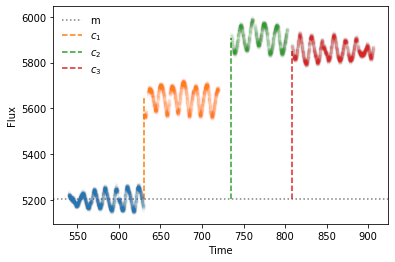

In [2]:
qs = sorted(np.unique(tab['quarter']))
means = []
cycle_map = {}
for i, q in enumerate(qs):
    ind = tab['quarter']==q
    t = tab[ind]
    plt.errorbar(t['time'],t['flux'], yerr=t['error'], marker='.', linestyle='None', alpha=0.01)
    meanflux = np.mean(t['flux'])
    cycle_map[q] = ind
    means.append(meanflux)
    if i == 0:
        plt.axhline(meanflux, label='m', color='grey', ls=":")
    else:

        vmin = means[0]
        vmax = meanflux

        plt.plot((t['time'][0], t['time'][0]), (vmin, vmax), label=rf'$c_{i}$', color=f'C{i}', ls='--') 
    
plt.xlabel('Time')
plt.ylabel('Flux')
plt.legend(frameon=False)


### As you can see there is some kind of periodic singal, but it's not perfectly regular. There is also the usual offsets between Kepler photometry in different cycles.

### You'll need four parameters to describe constants ($m, c_1, c_2, c_3$) to renormalize the flux to the first cycle, illustrated in the figure above. 
### $m$ specifies the mean of the Gaussian process, while $c_1, c_2, c_3$ are nuisance parameters. 

### You know how to implement a model with one common zeropoint and multiple offsets - this was what you did on your midterm.


### You'll also need some model to describe the quasi-periodic oscillations. There's no good way to write down a model in real for these in real space because stellar magnetic fields are incredibly complicated. 

### Instead we'll write down a model for the covariance between the observations and use a Gaussian process to model the star. You can model quasi-periodic correlation structure as something periodic + something that varies the periodicity smoothly:

## $$k(t_i, t_j) = A\cdot \exp\left(-\Gamma_1\cdot \sin^2\left(\frac{\pi}{P}|t_i - t_j|\right) -  \frac{|t_i-t_j|^2}{\lambda}) \right) $$

### This is another 4 parameters, ($A, \Gamma_1, P, \lambda$) parameters for a total of 8: ($m, c_1, c_2, c_3, A, \Gamma_1, P, \lambda$)


<hr>

### Q1: To implement the GP correlations, use the `george` package to construct this quasi-periodic kernel
https://george.readthedocs.io/en/latest/user/kernels/


### In particular, you should be able to combine `ExpSine2Kernel` and `ExpSquaredKernel` to get a model for the quasi-periodic oscillations.

In [3]:
from george import kernels
def kernel(A, gamma, P, lamda):
    k1 = kernels.ExpSine2Kernel(gamma=gamma, log_period=P, ndim=1)
    k2 = kernels.ExpSquaredKernel(metric=lamda, metric_bounds=None, lower=True, block=None, bounds=None, ndim=1, axes=None)
    kernel = A * k1 * k2
    return kernel

k = kernel(1., 1., 2., 1.)

### Q2: To implement the full model, read how to use `george`'s modeling protocol:
https://george.readthedocs.io/en/latest/tutorials/model/

In [4]:
from george.modeling import Model

time = tab['time']
flux = tab['flux']
error = tab['error']
quarter = tab['quarter']

# from the plot above, guess:
m_0 = 5200
c1_0 = 5650-m_0
c2_0 = 5900-m_0
c3_0 = 5850-m_0

n6 = 0
n7 = 0
n8 = 0
n9 = 0
for i in range(0, len(time)):
    if quarter[i] == 6:
        n6 += 1
    elif quarter[i] ==7:
        n7 += 1
    elif quarter[i] ==8:
        n8 += 1
    else:
        n9 += 1
        
tab6 = tab[0:n6][:]
tab7 = tab[n6:n6+n7][:]
tab8 = tab[n6+n7:n6+n7+n8][:]
tab9 = tab[n6+n7+n8::][:]

class Model(Model):
    parameter_names = ("m", "c1", "c2", "c3")

    def get_value(self, t):
        flux_new = flux.copy()
        flux_new[0:n6] = self.m
        flux_new[n6:n6+n7] = self.m + self.c1
        flux_new[n6+n7:n6+n7+n8] = self.m + self.c2
        flux_new[n6+n7+n8::] = self.m + self.c3
        return flux_new

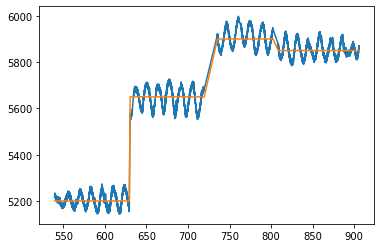

In [5]:
import numpy as np
import matplotlib.pyplot as pl
from george import kernels

# plot the model
flux_model = Model(m_0, c1_0, c2_0, c3_0).get_value(time)
plt.plot(time, flux)
plt.plot(time, flux_model)

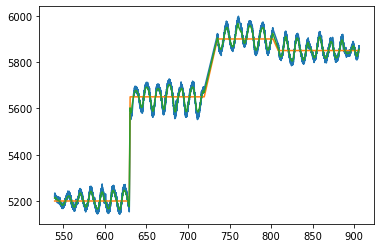

In [6]:
import george
mean_model = Model(m_0, c1_0, c2_0, c3_0)
gp = george.GP(k, mean=mean_model)
gp.compute(time, error)
# mu = gp.sample_conditional(flux, time)
mu, cov = gp.predict(flux, time)

plt.plot(time, flux, color = 'C0')
plt.plot(time, flux_model, color = 'C1')
plt.plot(time, mu, color = 'C2')

### Q3: With your model and likelihood constructured, write down priors on the parameters (you should be able to estimate from the plots)

In [7]:
def lnprob2(p):
    gp.set_parameter_vector(p)
    m = p[0]
    c1 = p[1]
    c2 = p[2]
    c3 = p[3]
    A = p[4]
    gamma = p[5]
    P = p[6]
    lamda = p[7]
#     From the plot
#     5000<m<5400; 400<c1<600; 600<c2<800; 600<c3<800
    if m > 5400 or m < 5000:
        return -np.inf
    if c1 > 600 or c1 < 400:
        return -np.inf
    if c2 > 800 or c2 < 600:
        return -np.inf
    if c3 > 800 or c3 < 600:
        return -np.inf
    if A > 10 or A < -10:
        return -np.inf
    if gamma > 10 or gamma < -10:
        return -np.inf
    if P > 10 or P < -10:
        return -np.inf
    if lamda > 10 or lamda < -10:
        return -np.inf
#     if A > 100 or A < -100:
#         return -np.inf
#     if gamma > 100 or gamma < -100:
#         return -np.inf
#     if P > 100 or P < -100:
#         return -np.inf
#     if lamda > 100 or lamda < -100:
#         return -np.inf

    
#     if 5000 < m < 5400:
#         return -np.inf
#     if 400 < c1 < 600:
#         return -np.inf
#     if 600 < c2 < 800:
#         return -np.inf
#     if 600 < c3 < 800:
#         return -np.inf
    return -gp.log_likelihood(flux, quiet=True) - gp.log_prior()

### Q4: Use `emcee` to optimize the model parameters and hyper-parameters, **using only every 10th sample in time**
### (Don't go overboard with the number of walkers or steps)
https://george.readthedocs.io/en/latest/tutorials/hyper/ may help

In [8]:
import emcee

initial = gp.get_parameter_vector()
ndim, nwalkers = len(initial), 32
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob2)

print("Running first burn-in...")
p0 = initial + 1e-4 * np.random.randn(nwalkers, ndim)
p0, lp, _ = sampler.run_mcmc(p0, 10)

print("Running second burn-in...")
p0 = p0[np.argmax(lp)] + 1e-4 * np.random.randn(nwalkers, ndim)
sampler.reset()
p0, _, _ = sampler.run_mcmc(p0, 10)
sampler.reset()

print("Running production...")
sampler.run_mcmc(p0, 20);

# Something must be wrong. It keeps running and doesn't stop.

Running first burn-in...
emcee: Exception while calling your likelihood function:
  params: [ 5.20000009e+03  4.49999871e+02  6.99999934e+02  6.49999863e+02
 -1.13222208e-04  9.99862169e-01  1.99997696e+00  1.29768899e-05]
  args: []
  kwargs: {}
  exception:


Traceback (most recent call last):
  File "/Users/siriuslee/opt/anaconda3/lib/python3.7/site-packages/emcee/ensemble.py", line 545, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "<ipython-input-7-020a49fceef2>", line 47, in lnprob2
    return -gp.log_likelihood(flux, quiet=True) - gp.log_prior()
  File "/Users/siriuslee/opt/anaconda3/lib/python3.7/site-packages/george/gp.py", line 360, in log_likelihood
    if not self.recompute(quiet=quiet):
  File "/Users/siriuslee/opt/anaconda3/lib/python3.7/site-packages/george/gp.py", line 332, in recompute
    self.compute(self._x, np.sqrt(self._yerr2), **kwargs)
  File "/Users/siriuslee/opt/anaconda3/lib/python3.7/site-packages/george/gp.py", line 309, in compute
    self.solver.compute(self._x, yerr, **kwargs)
  File "/Users/siriuslee/opt/anaconda3/lib/python3.7/site-packages/george/solvers/basic.py", line 64, in compute
    K = self.kernel.get_value(x)
  File "/Users/siriuslee/opt/anaconda3/lib/python3.7/site-packages/geor

KeyboardInterrupt: 

Text(0.5, 0, 'Step')

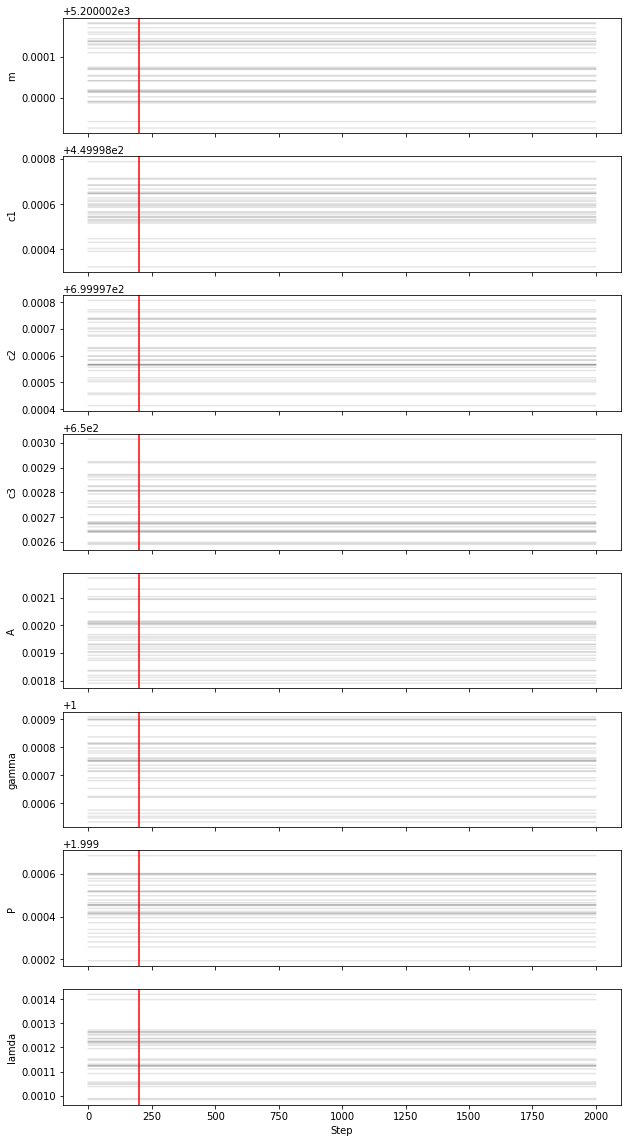

In [91]:
samp = sampler.get_chain()
labels = ['m', 'c1', 'c2', 'c3', 'A', 'gamma', 'P', 'lamda']

fig, axs = plt.subplots(nrows=ndim, ncols=1, figsize=(10, 20), sharex=True)
for i in range(ndim):
    ax = axs[i]
    ax.plot(samp[:,:,i], color='k', alpha=0.1 )
    ax.set_ylabel(labels[i])
#     ax.set_xlim(0, 2200)
    ax.axvline(200, color='red')
ax.set_xlabel('Step')

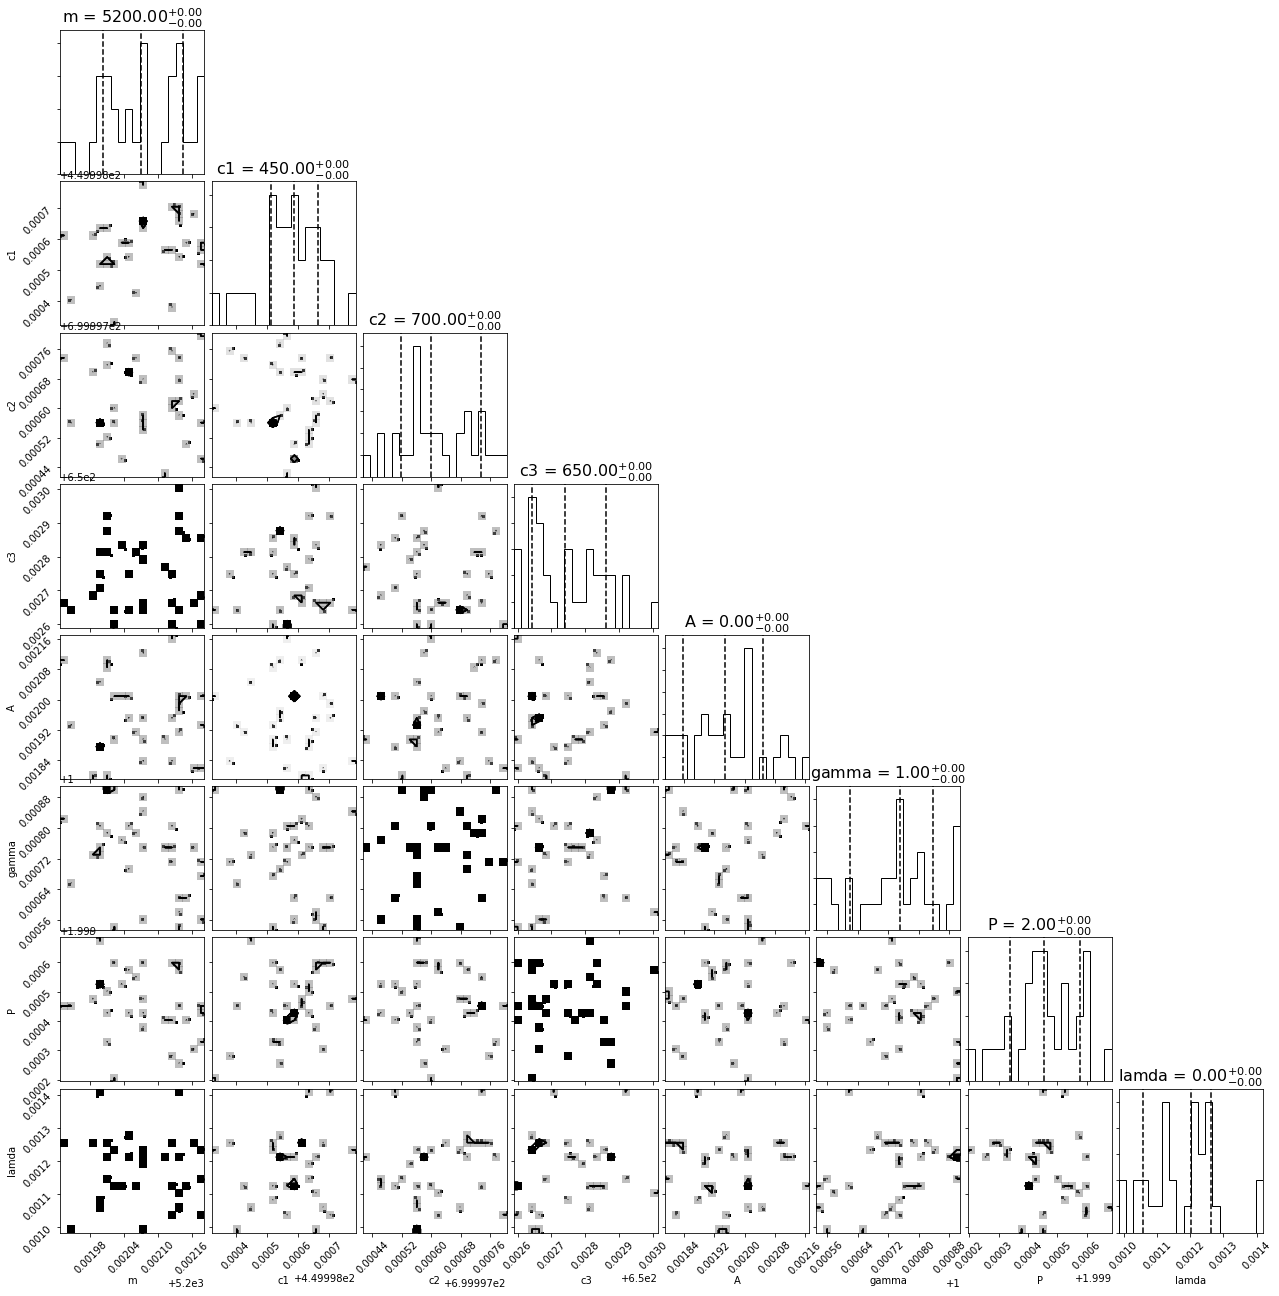

In [92]:
import corner
samp = samp.reshape((nwalkers*2000, ndim))
# make a corner plot
fig = corner.corner(samp, labels=labels, quantiles=[0.16, 0.5, 0.84],\
                       show_titles=True, title_kwargs={"fontsize": 16}) 

### Q5: Plot your posterior model over the data after correcting for the offsets, showing the points you used to condition the GP in red, and the remaining data in black. 

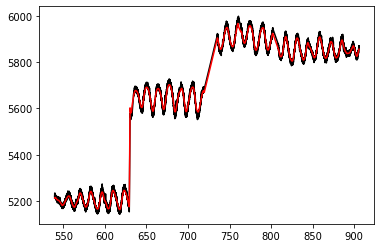

In [96]:
import george
mean_model = Model(m_0, c1_0, c2_0, c3_0)
gp = george.GP(k, mean=mean_model)
gp.compute(time, error)
# mu = gp.sample_conditional(flux, time)
mu, cov = gp.predict(flux, time)

plt.plot(time, flux, color = 'black')
# plt.plot(time, flux_model, color = 'C1')
plt.plot(time, mu, color = 'red')